# Daily coffee price

Precio diario del Café (creo que en EEUU) desde el 03-01-2000 hasta el 02-09-2020. Los valores están dados en USD.

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib notebook

## 1. Carga de Datos y análisis de la serie temporal

In [122]:
df = pd.read_csv('./data/coffee.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


In [123]:
df.tail()

,Date,Open,High,Low,Close,Volume,Currency
5741,2022-08-29,240.55,240.55,240.55,240.50,1,USD
5742,2022-08-30,238.75,241.75,238.75,239.15,14,USD
5743,2022-08-31,240.75,240.75,239.65,239.10,12,USD
5744,2022-09-01,238.55,238.55,236.60,236.35,6,USD
5745,2022-09-02,232.50,234.05,228.28,228.42,0,USD


<IPython.core.display.Javascript object>


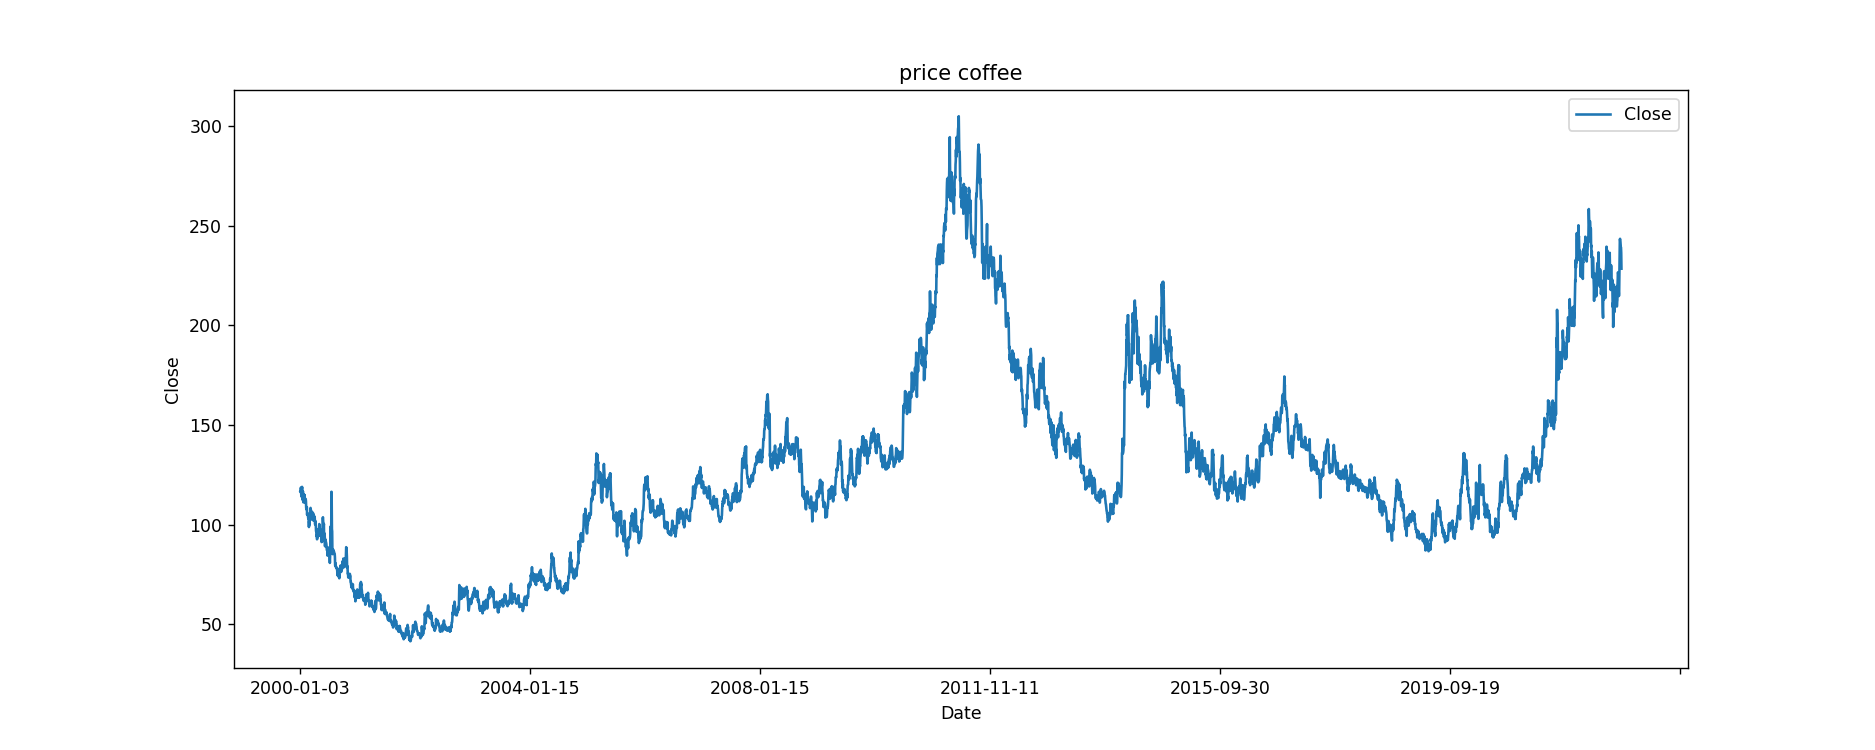

In [115]:
df.plot(x = "Date", y= "Close", figsize=(15, 6))
plt.title(f'price coffee')
plt.xlabel('Date')
plt.ylabel("Close")
plt.show()

### Descripción de las observaciones 

La serie parece no presentar ciclos ni estaciones marcadas. Es no acotada, tiene su punto máximo de aproximandamente 300 USD al rededor del año 2011 y un punto mínimo por debajo de los 50 USD en el año 2002 o 2003 aproximadamente. En principio pareciera no estacionaria porque la varianza bastante variable. Pareciera tener una tendencia a crecer muy suave.

<IPython.core.display.Javascript object>


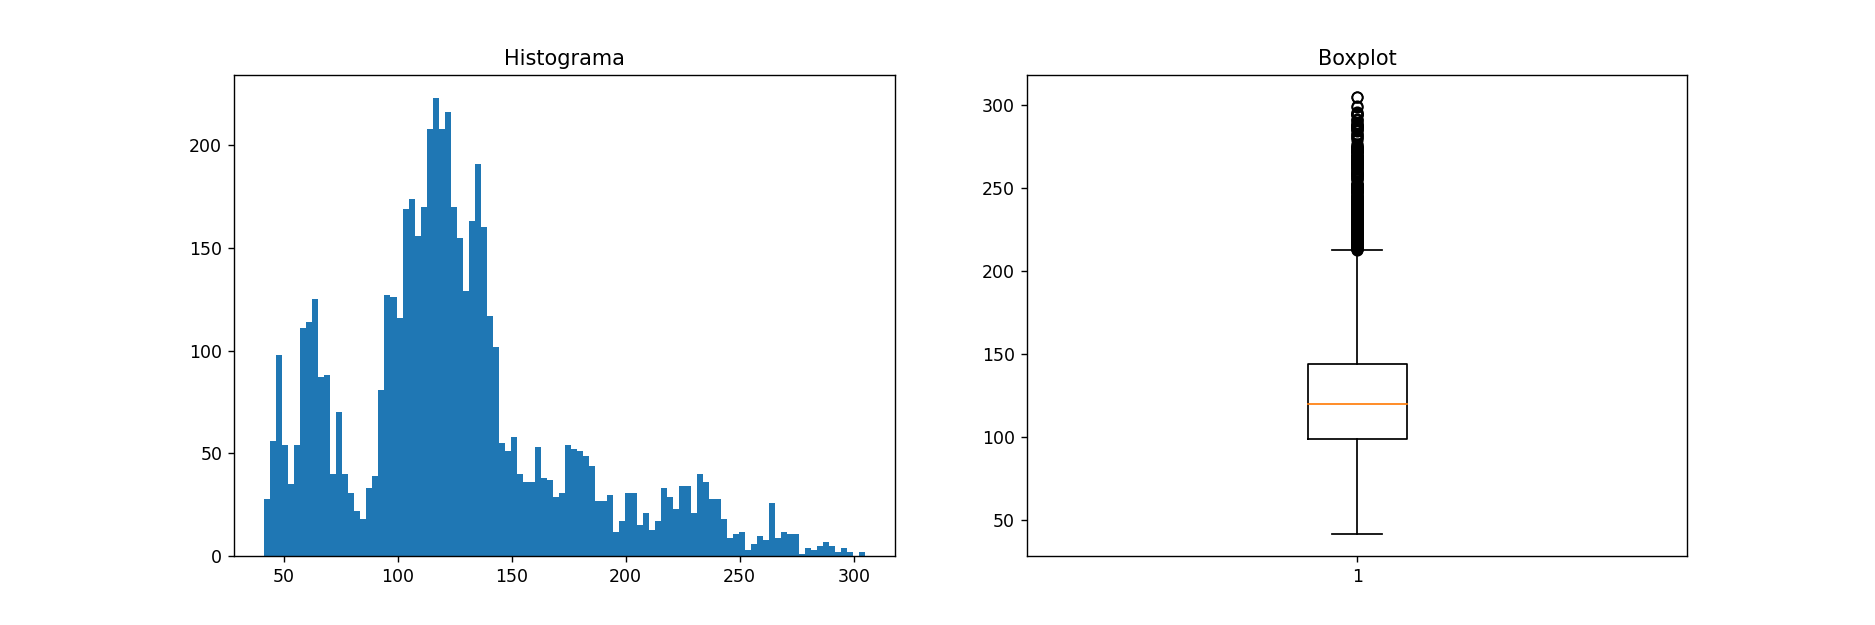

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
ax1.set_title('Histograma')
ax1.hist(df["Close"], bins = 100)
ax2.set_title("Boxplot")
ax2.boxplot(df["Close"])

plt.show()

si observamos la distribución tiene una especie de asimetría positiva, sin embargo no parece tener una distribución reconocible.

## 2. Descomposición con el modelo aditivo

In [124]:
period = 300
df_1 = df.set_index(pd.DatetimeIndex(df['Date']))
df_1.sort_index(ascending=True, inplace=True)
df_1=df_1['Close']

<IPython.core.display.Javascript object>


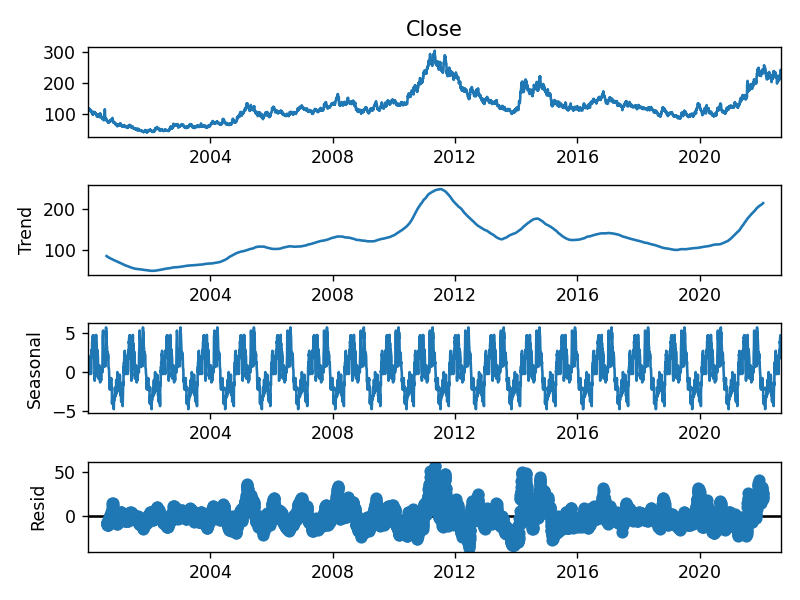

In [125]:
decompose = seasonal_decompose(df_1, model='additive', period=period)
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
decompose.plot();

## 3. Ajuste de modelo determinístico a la tendencia

Se ajusta un modelo lineal a la tendencia dado que no se observa que la tendencia sea cíclica. Se ajustan también tres curvas exponenciales para probar cual de todos los modelos se ajusta mejor a la tendencia. 

<IPython.core.display.Javascript object>


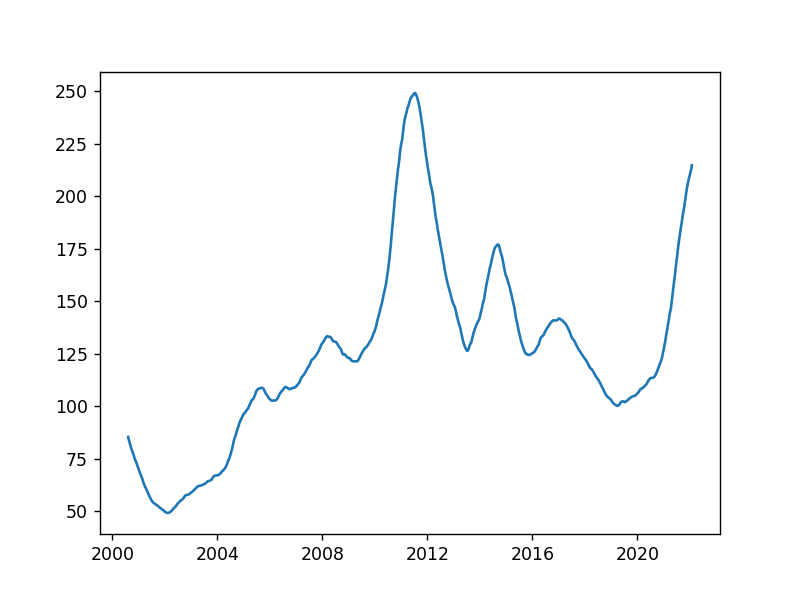

In [9]:
#graficamos la tendencia obtenida de la descomposición
plt.plot(trend)

### 3.1 Ajuste de una línea

In [19]:
def objective(x,a,b):
    return a * x + b 

In [20]:
x = np.linspace(0, 5445, 5446)
y = trend.dropna(axis=0)

popt, _ = curve_fit(objective, x, y)
a, b = popt
y_line = objective(x,a,b)

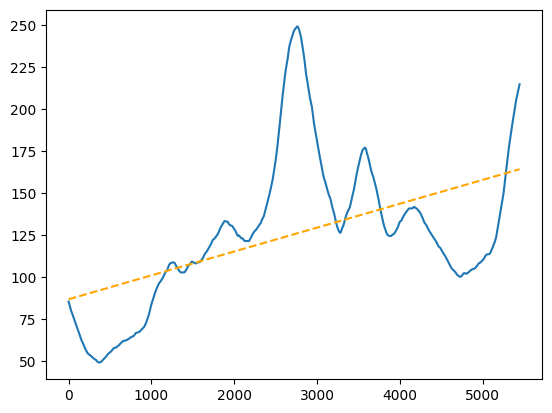

In [21]:
plt.plot(x,y)
plt.plot(x, y_line, '--', color = 'orange')

Podemos ver que lo que se había observado en la primera descripción sobre la tendencia a crecer sutilmente se corroborar con el ajuste de un modelo lineal. 

### 3.2 Ajuste de curva exponencial

In [80]:
def exponential(x,a):
    return a**x

In [84]:
x_2 = np.linspace(0, 5445, 5446)
y_2 = trend.dropna(axis=0)

popt, _ = curve_fit(exponential, x_2, y_2)
a = popt
y_line = exponential(x_2,a)

<IPython.core.display.Javascript object>


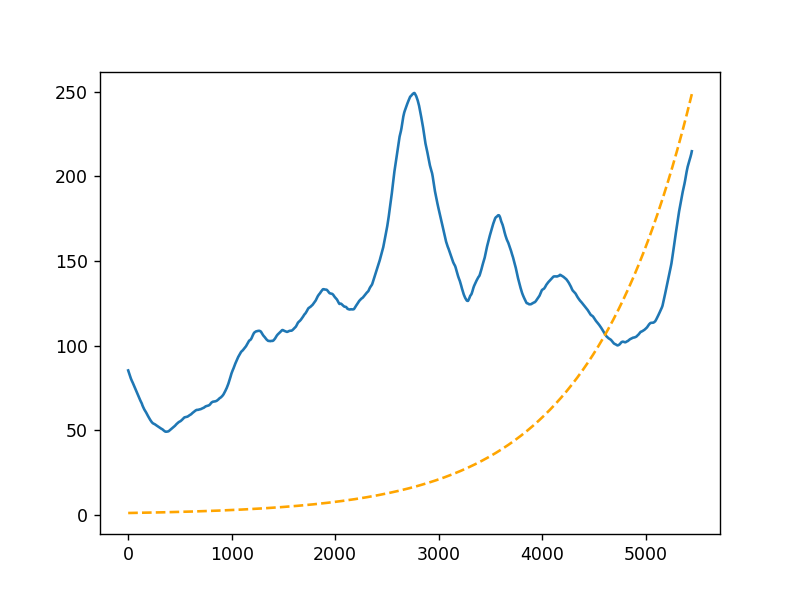

In [85]:
plt.plot(x_2,y_2)
plt.plot(x_2, y_line, '--', color = 'orange')

### 3.3 Ajuste de curva exponencial + constante fija

In [100]:
def exponential_2(x,a):
    return a**x + 80

In [101]:
x_3 = np.linspace(0, 5445, 5446)
y_3 = trend.dropna(axis=0)

popt, _ = curve_fit(exponential_2, x_3, y_3)
a = popt
y_line = exponential_2(x_3,a)

<IPython.core.display.Javascript object>


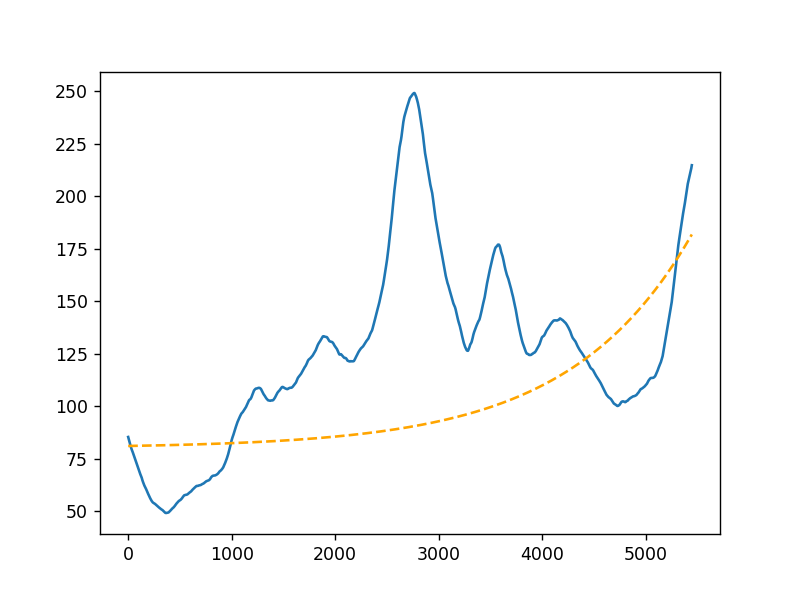

In [102]:
plt.plot(x_3,y_3)
plt.plot(x_3, y_line, '--', color = 'orange')

### 3.4 Ajuste de curva exponencial + constante variable

In [97]:
def exponential_3(x,a,b):
    return a**x + b

In [98]:
x_4 = np.linspace(0, 5445, 5446)
y_4 = trend.dropna(axis=0)

popt, _ = curve_fit(exponential_3, x_4, y_4)
a,b = popt
y_line = exponential_3(x_4,a, b)

<IPython.core.display.Javascript object>


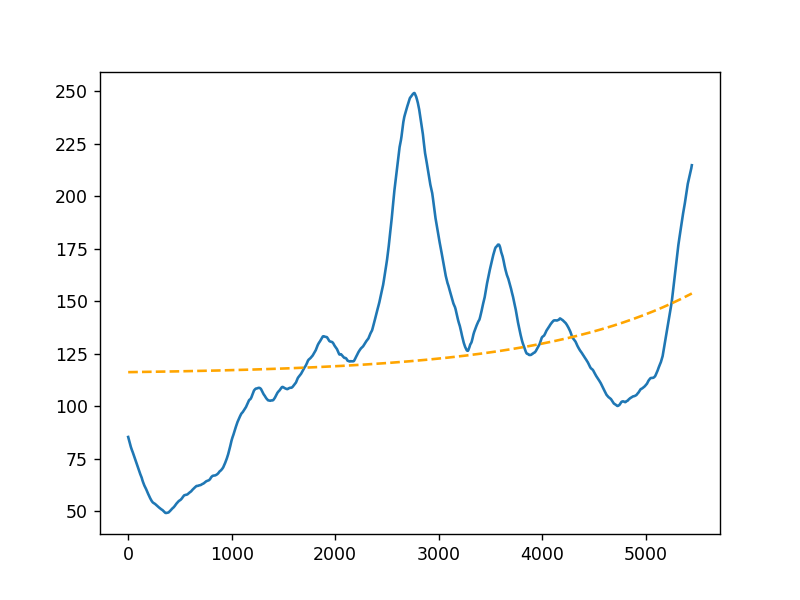

In [99]:
plt.plot(x_4,y_4)
plt.plot(x_4, y_line, '--', color = 'orange')

Podemos observar que el modelo que más se ajusta a la tendencia es en exponencial con un valor constante. Es una curva suave que describe el crecimiento de la tendencia. 

## 4. Estacionariedad

Si se observa la serie podemos ver que no parece tener una media constante en el tiempo y que su varianza tampoco lo es. Podemos observar la diferencia entre las varianza en el año 2000 que pequeña y la varianza en el año 2011 que es más grande. Por esta razón podríamos decir que pareciera no ser estacionaria. 

Para verificar su estacionariedad evaluaré primero su función de correlación y luego pasaré a los test de Dickey-Fuller y KPSS. 

Si llegase a no ser estacionaria, dependiendo de los resultados que arrojen los test y la función de autocorrelación, se procederá a la transformación de la serie. 

### 4.1 Verificación de estacionariedad

#### 4.1.1 Gráfica de autocorrealción

In [116]:
df.Date = pd.to_datetime(df.Date,yearfirst=True)
df.set_index('Date',inplace=True)
df = df.asfreq('b','ffill')

<IPython.core.display.Javascript object>


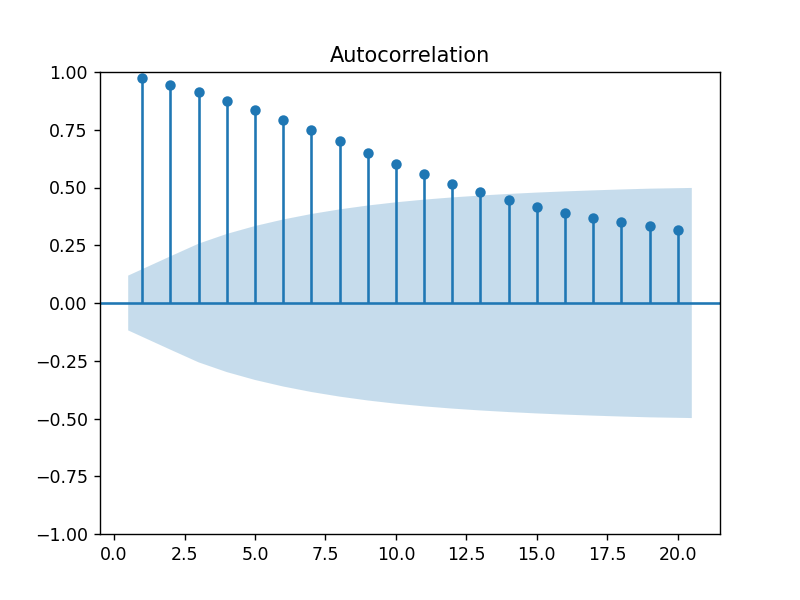

In [117]:
data = df.Close.resample('M').mean()
ax = fig.add_subplot(122)
plot_acf(data, lags=20, zero=False);

Vemos que la función de correlación tarda bastante en caer, es un primer indicio que la serie no es estacionaria.

#### 4.1.2 Test de Dickey-Fuller

In [24]:
test = adfuller(data)
test

(-1.4712344560827693,
 0.5476902360797826,
 2,
 270,
 {'1%': -3.4548039258751206,
  '5%': -2.872304928618605,
  '10%': -2.5725063100137175},
 1861.340990777597)

Observando el test tenemos:

Para el test de Dickey-Fuller la H0 es que (a-1) = 0. Esto quiere decir que basicamente lo que queremos rechazar es que haya un random walk.

Para el resultado de nuestro test tenemos que el p-valor es 0.54. Es bastante grande y de entrada nos dice que no podemos rechazar H0 por lo tanto no es estacionaria.

Si comparamos el estadístico con el umbral 0.05 tenemos que igual es más grande por lo tanto es no estacionaria. 

#### 4.1.3 Test KPSS

In [25]:
kpsstest = kpss(data)
kpsstest

D:\FACULTAD\ESPECIALIZACIÓN\4. CUARTO BIMESTRE\Series_temporales\env\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.9257997214985456,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Podemos ver que el p-valor para este test es menor que el umbral 0.05. Por lo tanto rechazamos la hipótesis nula lo que nos arroja que para este test la serie no es estacionaria. 

Los resultados que obtenemos para ambos test es que no es estacionaria. Lo que debemos hacer es transformar la serie con algún método para llegar a una serie estacionaria.


### 4.2 Transformación

Como queremos remover la tendencia podemos usar el método de diferenciación y volver a probar los test sobre la serie transformada. 

<IPython.core.display.Javascript object>


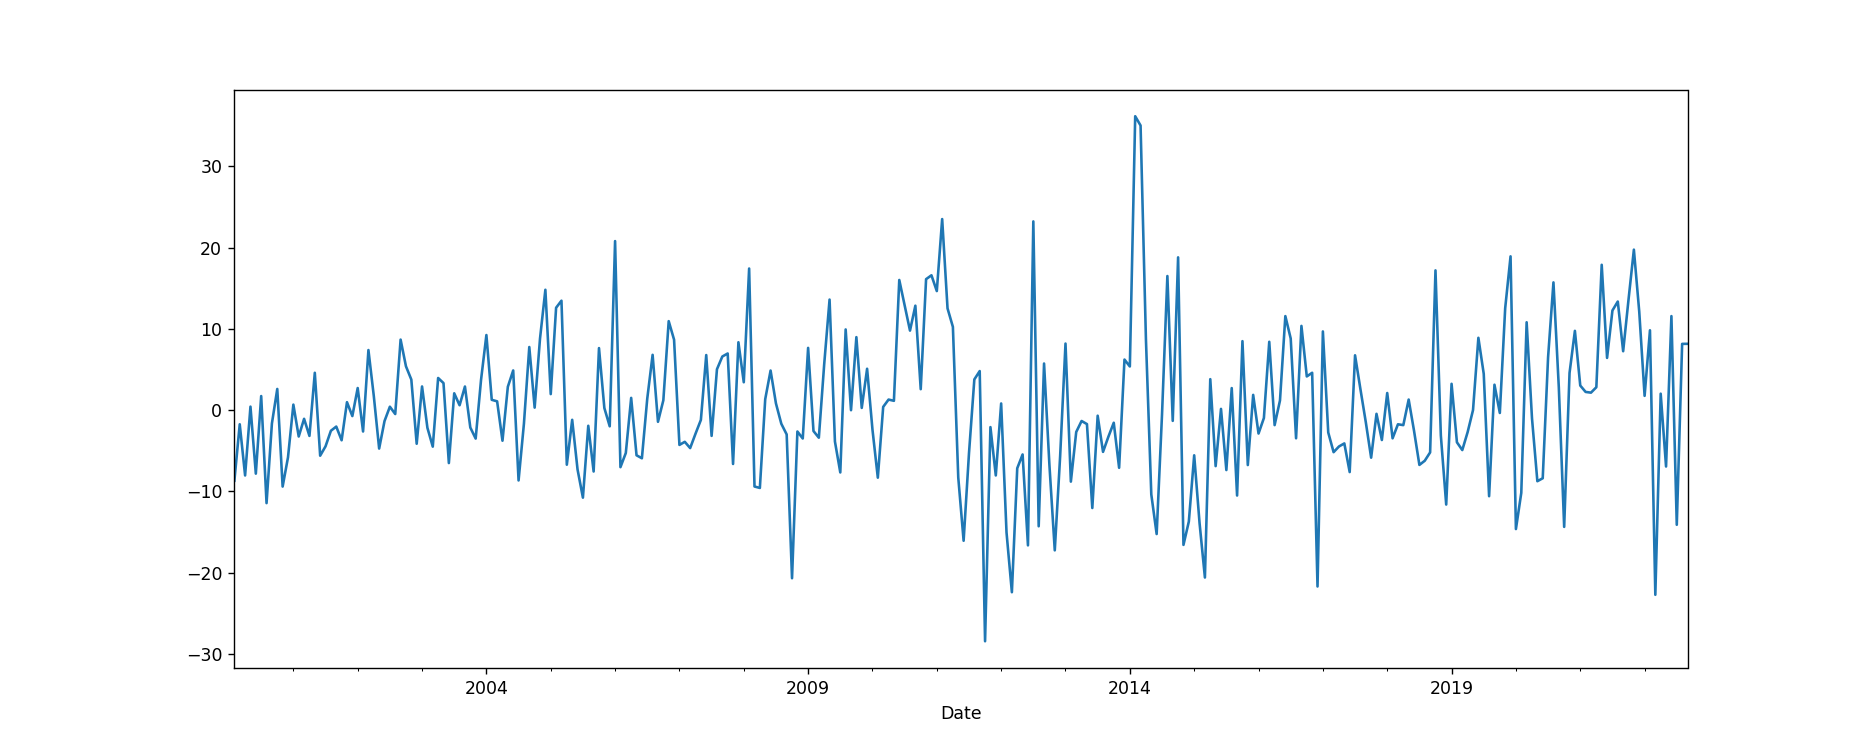

<AxesSubplot:xlabel='Date'>

In [296]:
data_diff = data.diff(1)
data_diff.dropna().plot(figsize=(15, 6))

Probamos los test sobre la serie transformada.

In [27]:
test_diff = adfuller(data_diff.dropna())
test_diff

(-13.472400425062371,
 3.362485782354874e-25,
 0,
 271,
 {'1%': -3.4547128138328875,
  '5%': -2.8722649771800155,
  '10%': -2.5724850011573914},
 1855.2452896538448)

Verificamos que el p-valor es bastante más pequeño que 0.05. Por lo tanto esta serie transformada es estacionaria.

In [28]:
kpss_diff = kpss(data_diff.dropna())
kpss_diff

D:\FACULTAD\ESPECIALIZACIÓN\4. CUARTO BIMESTRE\Series_temporales\env\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.10385434373502718,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Verificamos que el p-valor es mayor a 0.05 por lo tanto para este test la serie también es estacionaria. 

## 5. Ajuste de modelos (S)ARIMA

Para el ajuste de los modelos se analizan las funciones de correlación y correlación parcial para determinar ordenes de los modelos a testear.

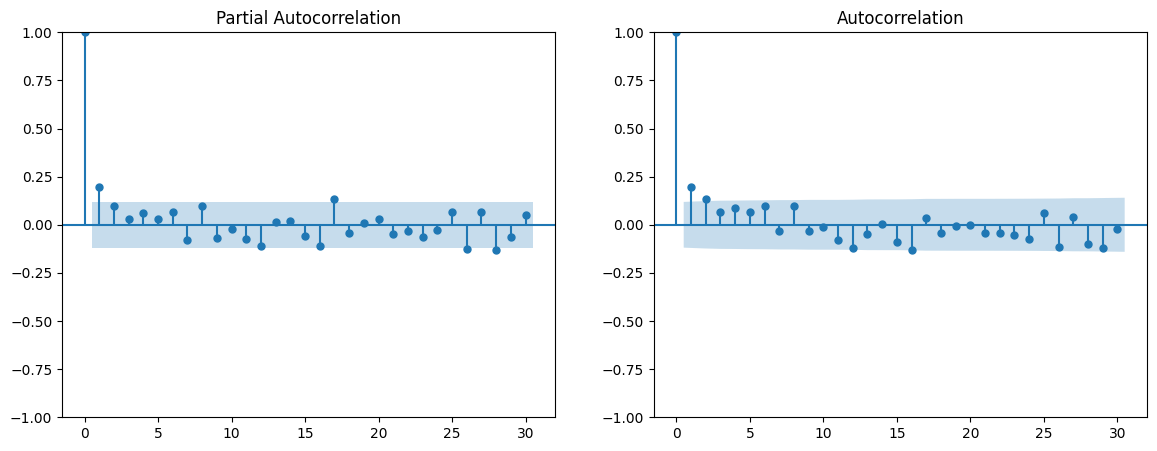

In [29]:
fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
plot_pacf(data_diff.dropna() ,lags=30, method ="ywm", ax=ax_1)

ax_2 = fig.add_subplot(122)
plot_acf(data_diff.dropna(), lags=30, ax=ax_2);

Después de hacer el análisis sobre la serie diferenciada tenemos algunos ordenes para poder armar algunos modelos ARIMA. Por ahora pareciera no tener un factor seasonal, veremos cómo se comportan los modelos. 

Si vemos la función de autocorrelación podríamos decir la parte MA puede ser de orden 1 o 2.
Si vemos la función de autocorrelación parcial podríamos decir que la parte AR es orden 1.

Como vimos anteriormente, diferenciamos una sola vez para sacar la tendencia y llegar a una serie estacionaria. Por lo tanto, el valor para d es 1. 

In [126]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

#### 1. Modelo con ordenes p = 1, d= 1, q= 1

In [191]:
model = ARIMA(data.values, order=(1,1,1), seasonal_order=(0,0,0,0))
model_fit = model.fit()

In [192]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -980.691
Date:                Fri, 07 Oct 2022   AIC                           1967.381
Time:                        16:09:20   BIC                           1978.198
Sample:                             0   HQIC                          1971.724
                                - 273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7256      0.124      5.832      0.000       0.482       0.969
ma.L1         -0.5639      0.150     -3.751      0.000      -0.859      -0.269
sigma2        79.2669      5.548     14.287      0.0

<IPython.core.display.Javascript object>


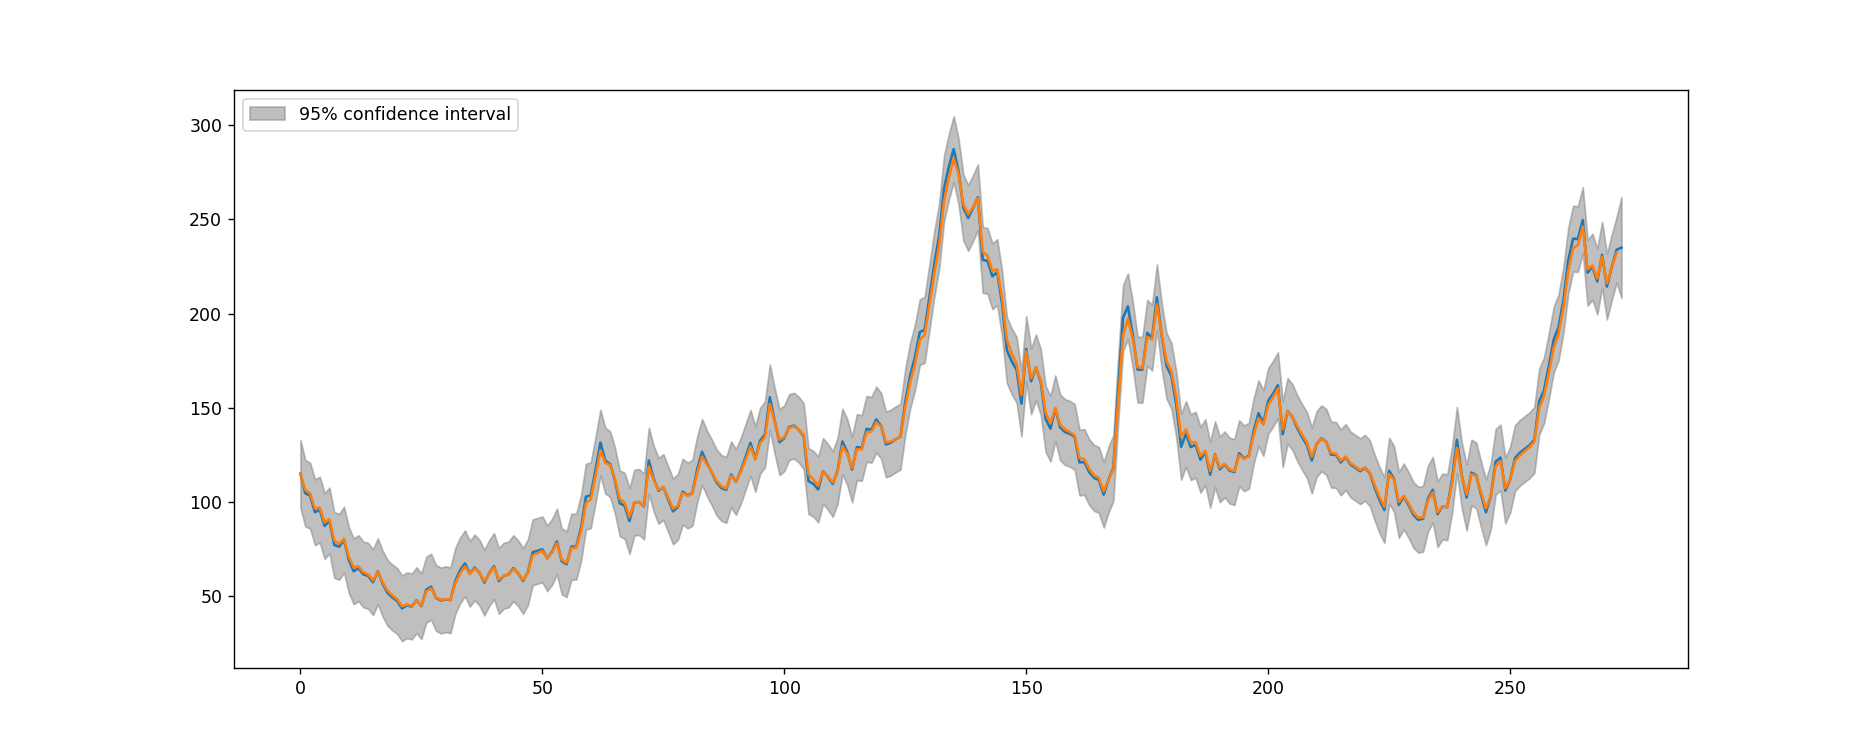

In [252]:
fig, ax = plt.subplots(figsize=(15,6))
fig = plot_predict(model_fit, start= 1, end=len(data.values) +1 , ax=ax)
plt.plot(data.values)
legend = ax.legend(loc="upper left")

#### 2. Modelo con ordenes p=1, d=1, q=2

In [196]:
model_2 = ARIMA(data.values, order=(1,1,2), seasonal_order=(0,0,0,0))
model_2_fit = model_2.fit()

In [197]:
print(model_2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -980.659
Date:                Fri, 07 Oct 2022   AIC                           1969.319
Time:                        16:10:34   BIC                           1983.742
Sample:                             0   HQIC                          1975.109
                                - 273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7495      0.180      4.153      0.000       0.396       1.103
ma.L1         -0.5809      0.189     -3.078      0.002      -0.951      -0.211
ma.L2         -0.0175      0.078     -0.225      0.8

<IPython.core.display.Javascript object>


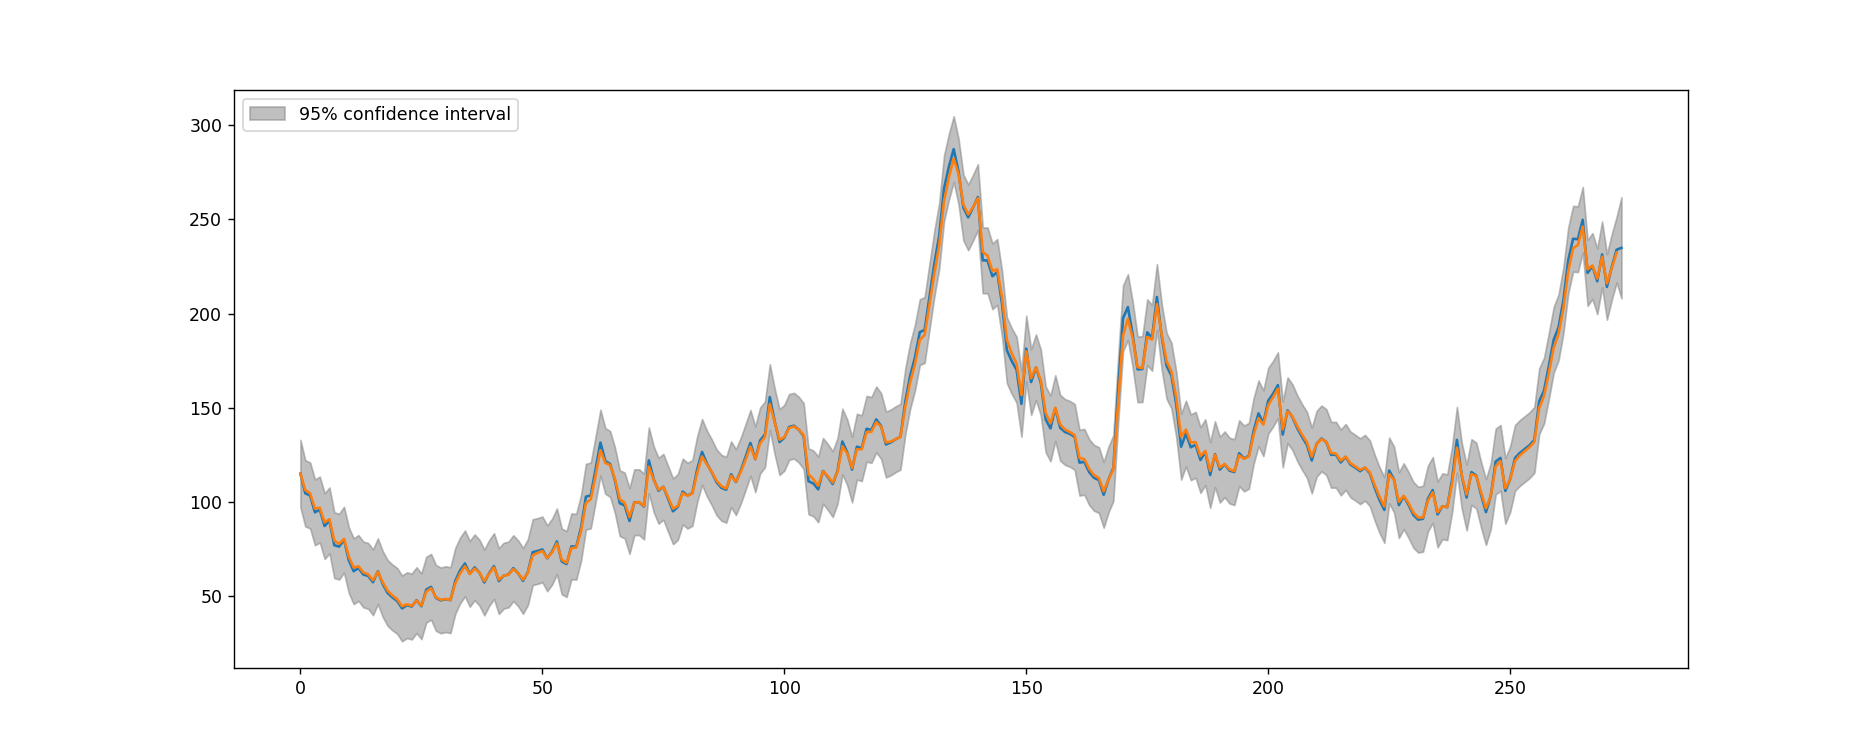

In [253]:
fig, ax = plt.subplots(figsize=(15,6))
fig = plot_predict(model_2_fit, start= 1, end=len(data.values) +1 , ax=ax)
plt.plot(data.values)
legend = ax.legend(loc="upper left")
plt.show()

#### 3. Modelo con ordenes p=1, d=2, q=1

In [201]:
model_3 = ARIMA(data.values, order=(1,2,1), seasonal_order=(0,0,0,0))
model_3_fit = model_3.fit()

In [202]:
print(model_3_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -981.908
Date:                Fri, 07 Oct 2022   AIC                           1969.816
Time:                        16:12:24   BIC                           1980.623
Sample:                             0   HQIC                          1974.155
                                - 273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1991      0.049      4.082      0.000       0.104       0.295
ma.L1         -0.9999      1.002     -0.998      0.318      -2.964       0.964
sigma2        80.6062     82.246      0.980      0.3

<IPython.core.display.Javascript object>


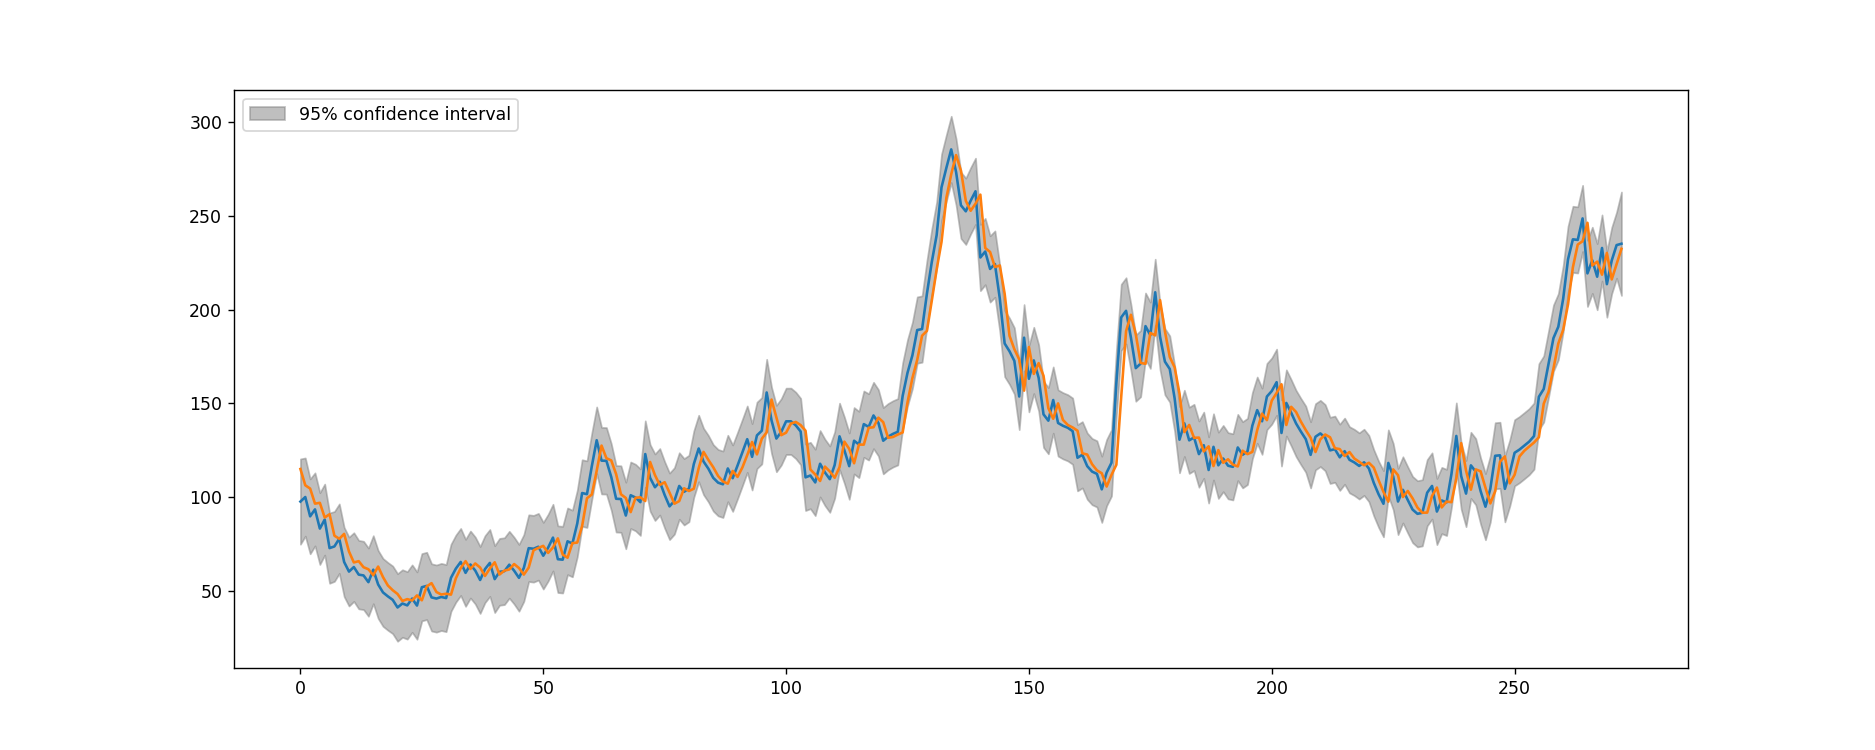

In [256]:
fig, ax = plt.subplots(figsize=(15,6))
fig = plot_predict(model_3_fit, start=2, end=len(data.values) +1 , ax=ax)
plt.plot(data.values)
legend = ax.legend(loc="upper left")
plt.show()

Análisis de resultados:

|Modelo | p | d | q | AIC | BIC|
|:-------:|:---:|:---:|:---:|:-----:|:----:|
|1 | 1 | 1 | 1 |1967.381 | 1978.198|
|2 | 1 | 1 | 2 |1969.319 | 1983.742|
|3 | 1 | 2 | 1 |1969.816 |1980.623|

Haciendo el análisis de los criterios de información, tenemos que tanto para el akaike como para el Bayesiano el mejor modelo es el modelo 1. 




## 6. Diagnóstico de modelos

Ahora que tenemos que el mejor modelo es el número 1, pasamos a hacer un diagnostico del modelo analizando sus residuos. Analizaremos también el modelo 2.

### 6.1 Modelo 1: p=1, d=1, q=1

#### Análisis de residuos

<IPython.core.display.Javascript object>


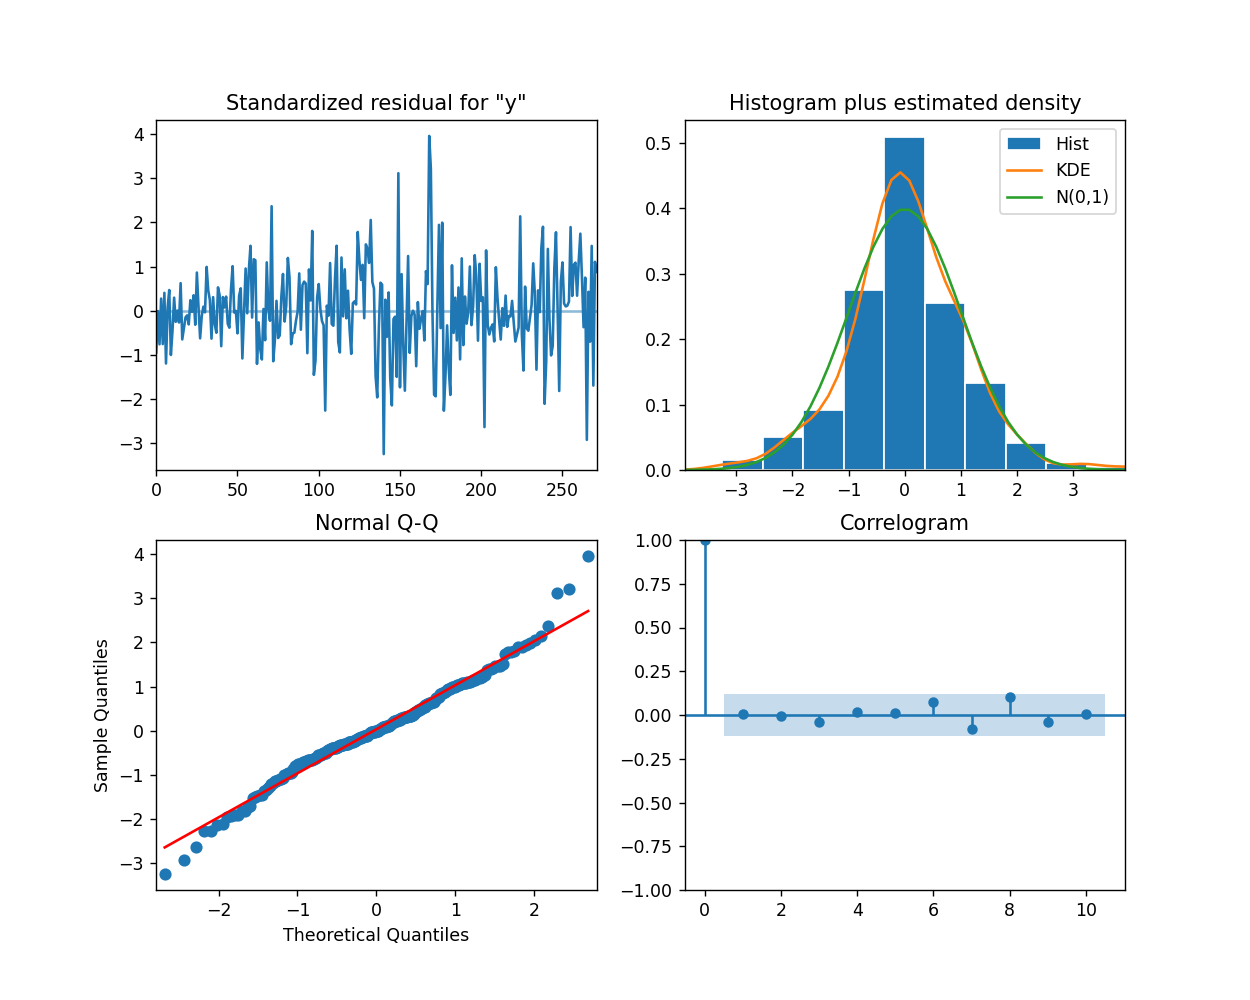

In [242]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

El qqplot para los residuos nos muestra  que la gausianidad está bastante bien. Por otro lado, la función de correlación nos muestra que los residuos parecen no tener correlación. 

El test de Ljung-Box para este modelo tiene un p-valor de 0.92 con lo cual no rechazamos y quiere decir que los residuos no están correlacionados. 

### 6.2 Modelo 2: p=1, d=1, q=2

#### Análisis de residuos

<IPython.core.display.Javascript object>


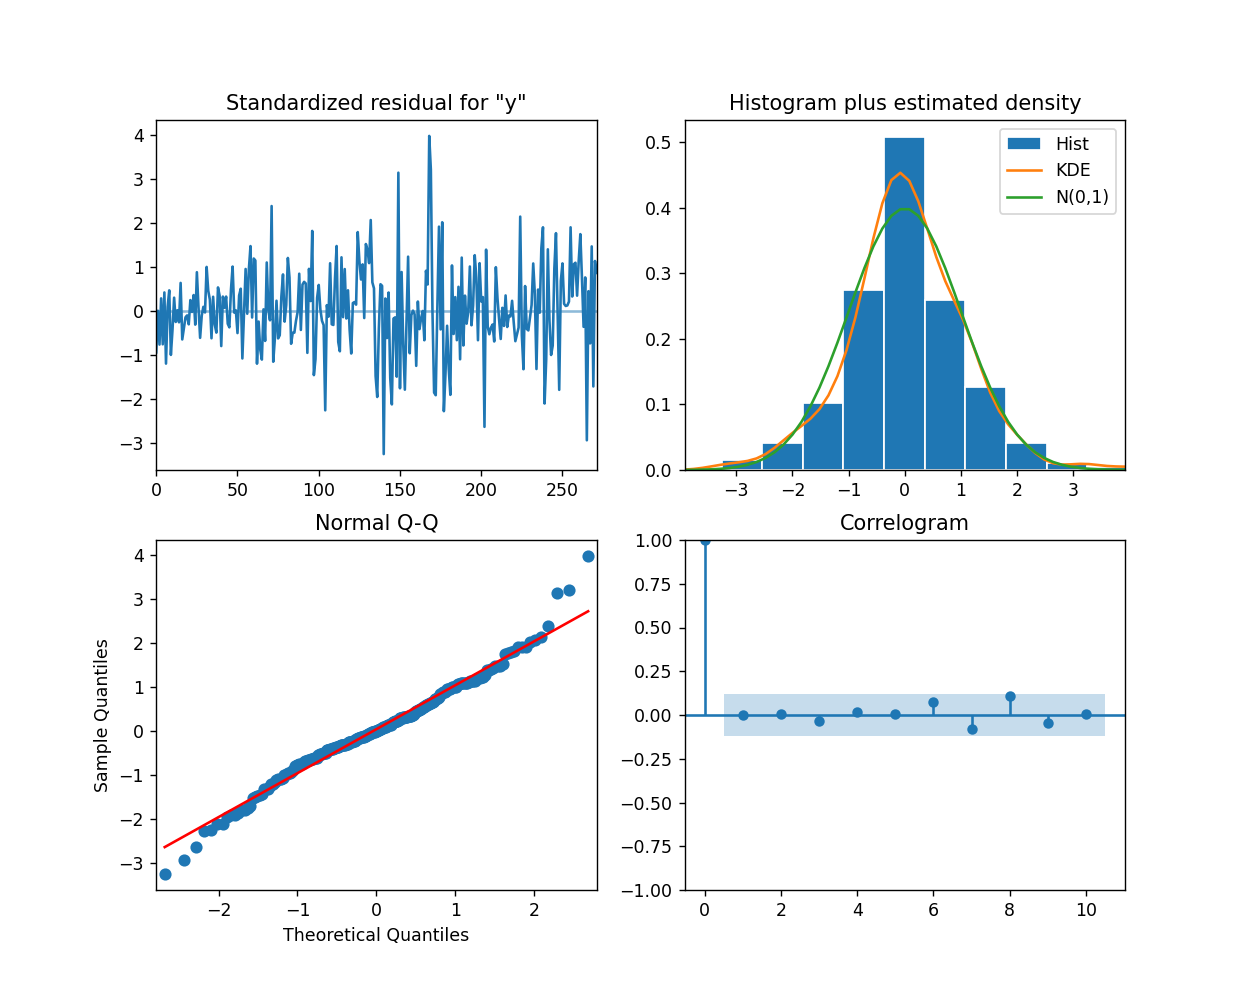

In [240]:
model_2_fit.plot_diagnostics(figsize=(10,8))
plt.show()

El test de Ljung-Box para este modelo tiene un p-valor de 0.97 con lo cual no rechazamos y quiere decir que los residuos no están correlacionados. 

Viendo el análisis de residuos ambos modelos arrojan buenos resultados, sin embargo al hacer un análisis sobre los errores de los coeficientes de ambos modelos podemos ver que quizás ninguno de los dos es tan bueno como quiseramos. Podemos contemplar la idea de un modelo mejor y ver que tanto mejor es en comparación a cualquiera de estos dos. 

### Nuevo modelo 4: p=0, d=1, q=2 P=1 D=1 Q=1 s=12

Volviendo a mirar la función de correlación parcial, podemos ver un punto en 12 que se sale muy poco del intervalo de confianza. Podemos probar un nuevo modelo con estos nuevos ordenes.

In [161]:
model_4 = ARIMA(data, order=(0,1,2), seasonal_order=(1,1,1,12))
model_4_fit = model_4.fit()

In [162]:
print(model_4_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  273
Model:             ARIMA(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -959.156
Date:                            Fri, 14 Oct 2022   AIC                           1928.312
Time:                                    15:15:13   BIC                           1946.116
Sample:                                01-31-2000   HQIC                          1935.469
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1576      0.050      3.140      0.002       0.059       0.256
ma.L2          0.1179      0.066   

#### Análisis de residuos

<IPython.core.display.Javascript object>


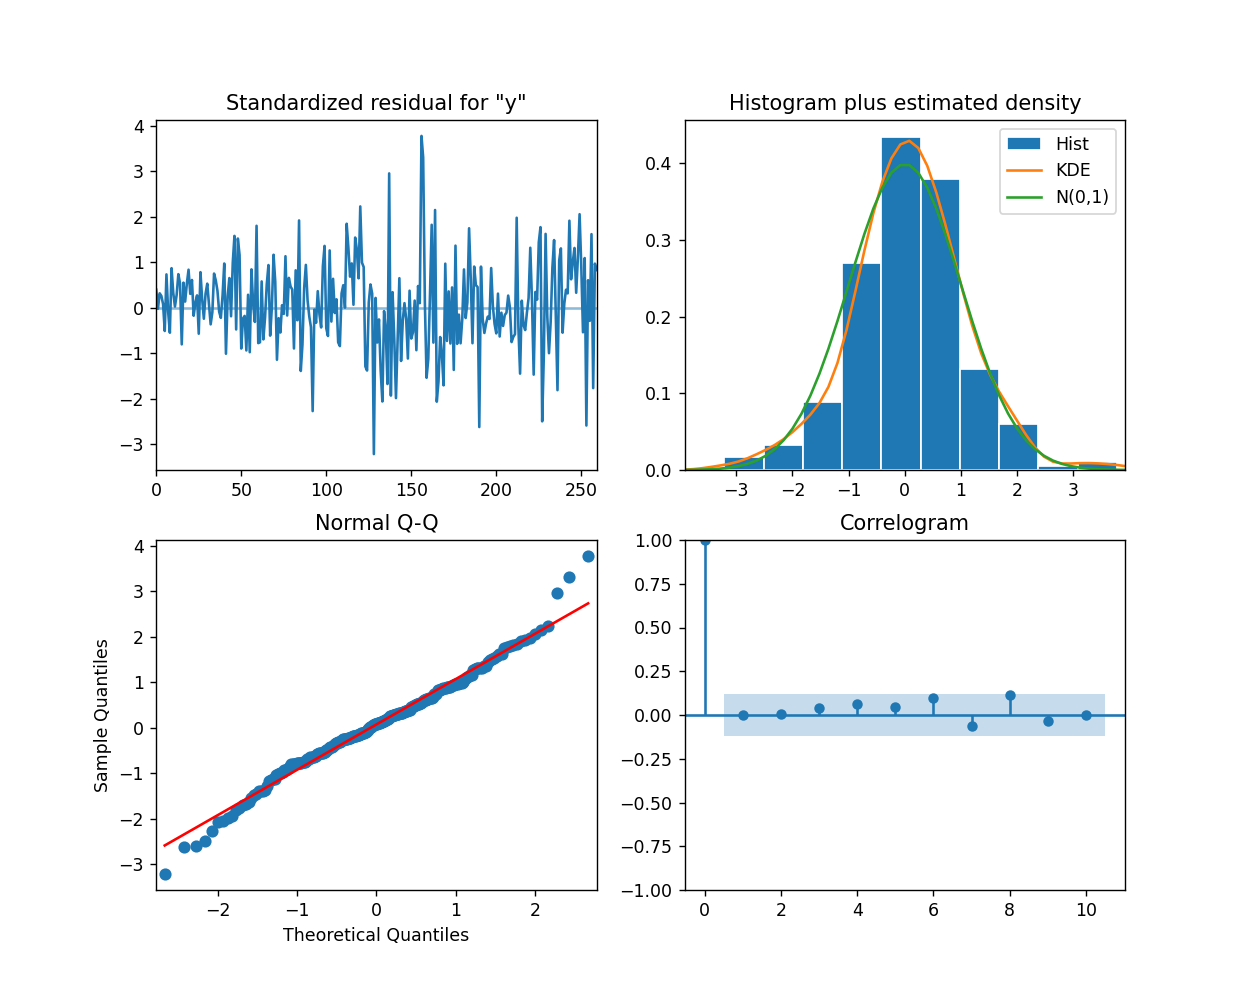

In [311]:
model_4_fit.plot_diagnostics(figsize=(10,8))
plt.show()

Analizando los resultado de este último modelo, podemos ver que efectivamente la serie si tiene una seasonal que no estaba siendo contemplada en los anteriores modelos. En este cuarto modelo el error de los coeficientes es mucho menor que los anteriores y tanto el AIC como el BIC son menores también. 

|Modelo | p | d | q | P| D | Q |s| AIC | BIC|
|:-----:|:-:|:-:|:-:|:-:|:-:|:--:|:--:|:--:|:--:|
|1 | 1 | 1 | 1 |0|0|0|0|1967.381 | 1978.198|
|2 | 1 | 1 | 2 |0|0|0|0|1969.319 | 1983.742|
|3 | 1 | 2 | 1 |0|0|0|0|1969.816 |1980.623|
|4 | 0 | 1 | 2 |1|1|1|12|1928.312 |1946.116|

## 7. Análisis espectral

In [118]:
from scipy import signal

In [119]:
N = len(data)

<IPython.core.display.Javascript object>


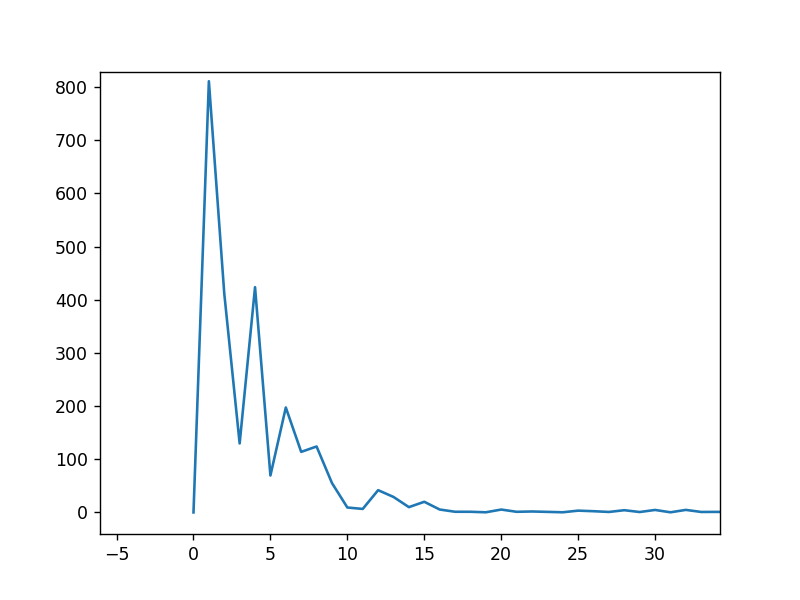

In [195]:
X = data.values
f, Pxx_den = signal.periodogram(X, N)
plt.plot(f, Pxx_den)
plt.show()

Teniendo en cuenta que el dataset está undersampleado a 1 muestra por mes, es decir que tenemos 12 muestras por año, los picos del periodograma nos indican que tenemos una ciclo principal cada 12 puntos y cada 3 puntos. Esto nos comprueba y verifica que el modelo al que le agregamos la componente seasonal tiene mejores resultados.

## 8. Predicciones

Haremos las predicciones para el modelo 4: p=0, d=1, q=2 P=1 D=1 Q=1 s=12.

Hacemos la división de train y test (que mantenemos también para las redes neuronales) y ajustamos el modelo a train para poder comparar resultado y calcular RSME con el dataset de test.

In [169]:
size = 0.7 ## train size
train, test = data.iloc[:int(size*len(data))], data.iloc[int(size*len(data)):]

In [177]:
model_4 = ARIMA(train, order=(0,1,2), seasonal_order=(1,1,1,12))
model_4_fit = model_4.fit()

In [178]:
print(model_4_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  191
Model:             ARIMA(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -658.966
Date:                            Fri, 14 Oct 2022   AIC                           1327.932
Time:                                    15:22:13   BIC                           1343.841
Sample:                                01-31-2000   HQIC                          1334.383
                                     - 11-30-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1697      0.060      2.836      0.005       0.052       0.287
ma.L2          0.2146      0.088   

<IPython.core.display.Javascript object>


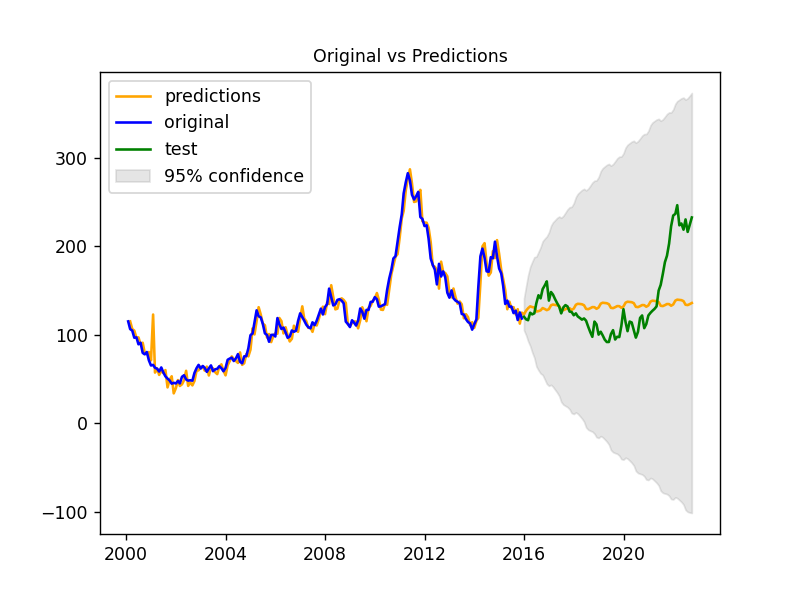

In [194]:
predictions = model_4_fit.get_prediction(start='2000-01-31',end='2022-09-30')
conf = predictions.conf_int()
test_conf = conf.loc[test.index[0]:]

plt.plot(predictions.predicted_mean[1:],color='orange',label='predictions')
plt.plot(train,color='blue',label='original')
plt.plot(test,color='green',label='test')
plt.fill_between(test_conf.index, test_conf.iloc[:,0], test_conf.iloc[:,1], color='gray', alpha=.2,label='95% confidence')
plt.title('Original vs Predictions',size=10)
plt.legend(loc='upper left')

In [190]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, mean_squared_error

print(f"Mean Absolute Error: {mean_absolute_error(test[1:],predictions.predicted_mean[1:])}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(test[1:],predictions.predicted_mean[1:])}")
print(f"RMSE: {np.sqrt(mean_squared_error(test[1:],predictions.predicted_mean[1:]))}")

Mean Absolute Error: 29.878685558559436
Mean Absolute Percentage Error: 0.20176349469435814
RMSE: 40.89392177006451


Como vemos, al ser un proceso no estacionario el error crece porque la serie de los coeficientes no se va haciendo más chica. Por lo tanto, a largo plazo, solo podremos predecir la tendencia. 